In [1]:
import sys, os
import utils

sys.path.insert(0, os.path.abspath('../DeepSplines'))
from deepsplines.ds_modules.deepBspline import DeepBSpline
from models import LinearBSpline


opt_params = {
        'size': 3,
        'range_': 1,
        'init': 'relu',
        'save_memory': False
}

bspline = DeepBSpline('fc', 8, **opt_params) # create a single BSpline Layer

locations = bspline.grid_tensor.detach()
coefficients = bspline.coefficients_vect.view(bspline.num_activations, bspline.size).detach()

# print(locations)
# print(coefficients)

# utils.plot_bspline(locs=locations[0].numpy(), coeffs=coefficients[0].numpy)


In [2]:
import linspline
import matplotlib.pyplot as plt
import numpy as np
import torch

import importlib

importlib.reload(linspline)

linspline = linspline.LinearSpline(locations[0], coefficients[0])

(locs, coeffs) = linspline.get_locs_coeffs()

x_plot = x_plot = torch.from_numpy(np.linspace(-1, 1, 400))
y_plot = linspline.forward(x_plot)


plt.figure(figsize=(8, 6))
plt.plot(x_plot, y_plot, label='Linear Spline', color='blue')
plt.scatter(locs, coeffs, color='red', label='Knot Points')
plt.title('Linear Spline Interpolation using NumPy.interp')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


AttributeError: module 'linspline' has no attribute 'LinearSpline'

Now copy model to model

In [3]:
model = LinearBSpline([8], 3, 1, 'relu') # create a BSpline based model

for layer in range(len(model.get_deepspline_activations())):
    locs = model.get_deepspline_activations()[layer]['locations']
    coeffs = model.get_deepspline_activations()[layer]['coefficients']

In [ ]:
# ! test timing on single bspline vs. linear spline vs. relu 

In [4]:
import linspline
import importlib

importlib.reload(linspline)

lin_model = linspline.LSplineFromBSpline(model.get_layers())

print("\n----\n")
print(lin_model.get_layers())


----

Sequential(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): LinearSplineLayer(locs=Tensor(shape=(8, 3)), coeffs=Tensor(shape=(8, 3)), mode='fc')
  (2): Linear(in_features=8, out_features=1, bias=True)
)


In [15]:
import linspline
import importlib
import time

import torch.nn as nn

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

importlib.reload(linspline)

housing = fetch_california_housing()
X, y = housing.data, housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, shuffle=True)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

loss_fn = nn.MSELoss()

model = LinearBSpline([8], 3, 1)

start_time = time.perf_counter()
_ = model(X_test)

end_time = time.perf_counter()
fwd_lat = (end_time - start_time) / len(X_test) * 1000 * 1000 # per sample latency: seconds -> nanoseconds
fwd_lat = round(fwd_lat, 4)

print(f"BSpline fwd lat: {fwd_lat}")

# ~ ---------

lin_model = linspline.LSplineFromBSpline(model.get_layers())

start_time = time.perf_counter()
_ = lin_model(X_test)

end_time = time.perf_counter()
fwd_lat = (end_time - start_time) / len(X_test) * 1000 * 1000 # per sample latency: seconds -> nanoseconds
fwd_lat = round(fwd_lat, 4)
print(f"LSpline fwd lat: {fwd_lat}")

# may need to continue training on the linear splines...

BSpline fwd lat: 0.3702
LSpline fwd lat: 0.3893


In [14]:
sys.path.insert(0, os.path.abspath('../DeepSplines'))
from deepsplines.ds_modules.deepBspline import DeepBSpline
import deepsplines
import utils

layer_locs = []
layer_coeffs = []
for layer in model.get_layers():
    if(type(layer) is deepsplines.ds_modules.deepBspline.DeepBSpline):
        layer_locs.append(layer.grid_tensor.detach())
        layer_coeffs.append(layer.coefficients_vect.view(layer.num_activations, layer.size).detach())

In [15]:
import linspline

layer_locs2 = []
layer_coeffs2 = []
for layer in lin_model.get_layers():
    if(type(layer) is not torch.nn.modules.linear.Linear):
        print(type(layer))
        (l2, c2) = layer.get_locs_coeffs()
        
        layer_locs2.append(l2)
        layer_coeffs2.append(c2)


<class 'linspline.LinearSplineLayer'>


## Here

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

from models import LinearBSpline

from torch.utils.data import TensorDataset, DataLoader

# Load the data
housing = fetch_california_housing()
X, y = housing.data, housing.target

# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, shuffle=True)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# using a dataloader to randomize batching
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)



bsm = LinearBSpline([24], 3, 1, "relu")
optimizer = optim.Adam(bsm.parameters_no_deepspline(), lr=0.001)
aux_optimizer = optim.Adam(bsm.parameters_deepspline(), lr=0.0001)
loss_fn = nn.MSELoss()  # mean square error
lmbda = 1e-4 # regularization weight

print("Init complete")

bsm.train()
for epoch in range(20):
    rloss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        aux_optimizer.zero_grad()

        y_pred = bsm(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss2 = loss + lmbda * bsm.TV2()
        loss2.backward()
        optimizer.step()
        aux_optimizer.step()
        
        rloss += loss
    if(epoch % 5 == 0):
        print(f"Epoch {epoch}: {rloss}")


Init complete
Epoch 0: 11747.3935546875
Epoch 5: 4668.59326171875
Epoch 10: 2706.205810546875
Epoch 15: 2034.5709228515625


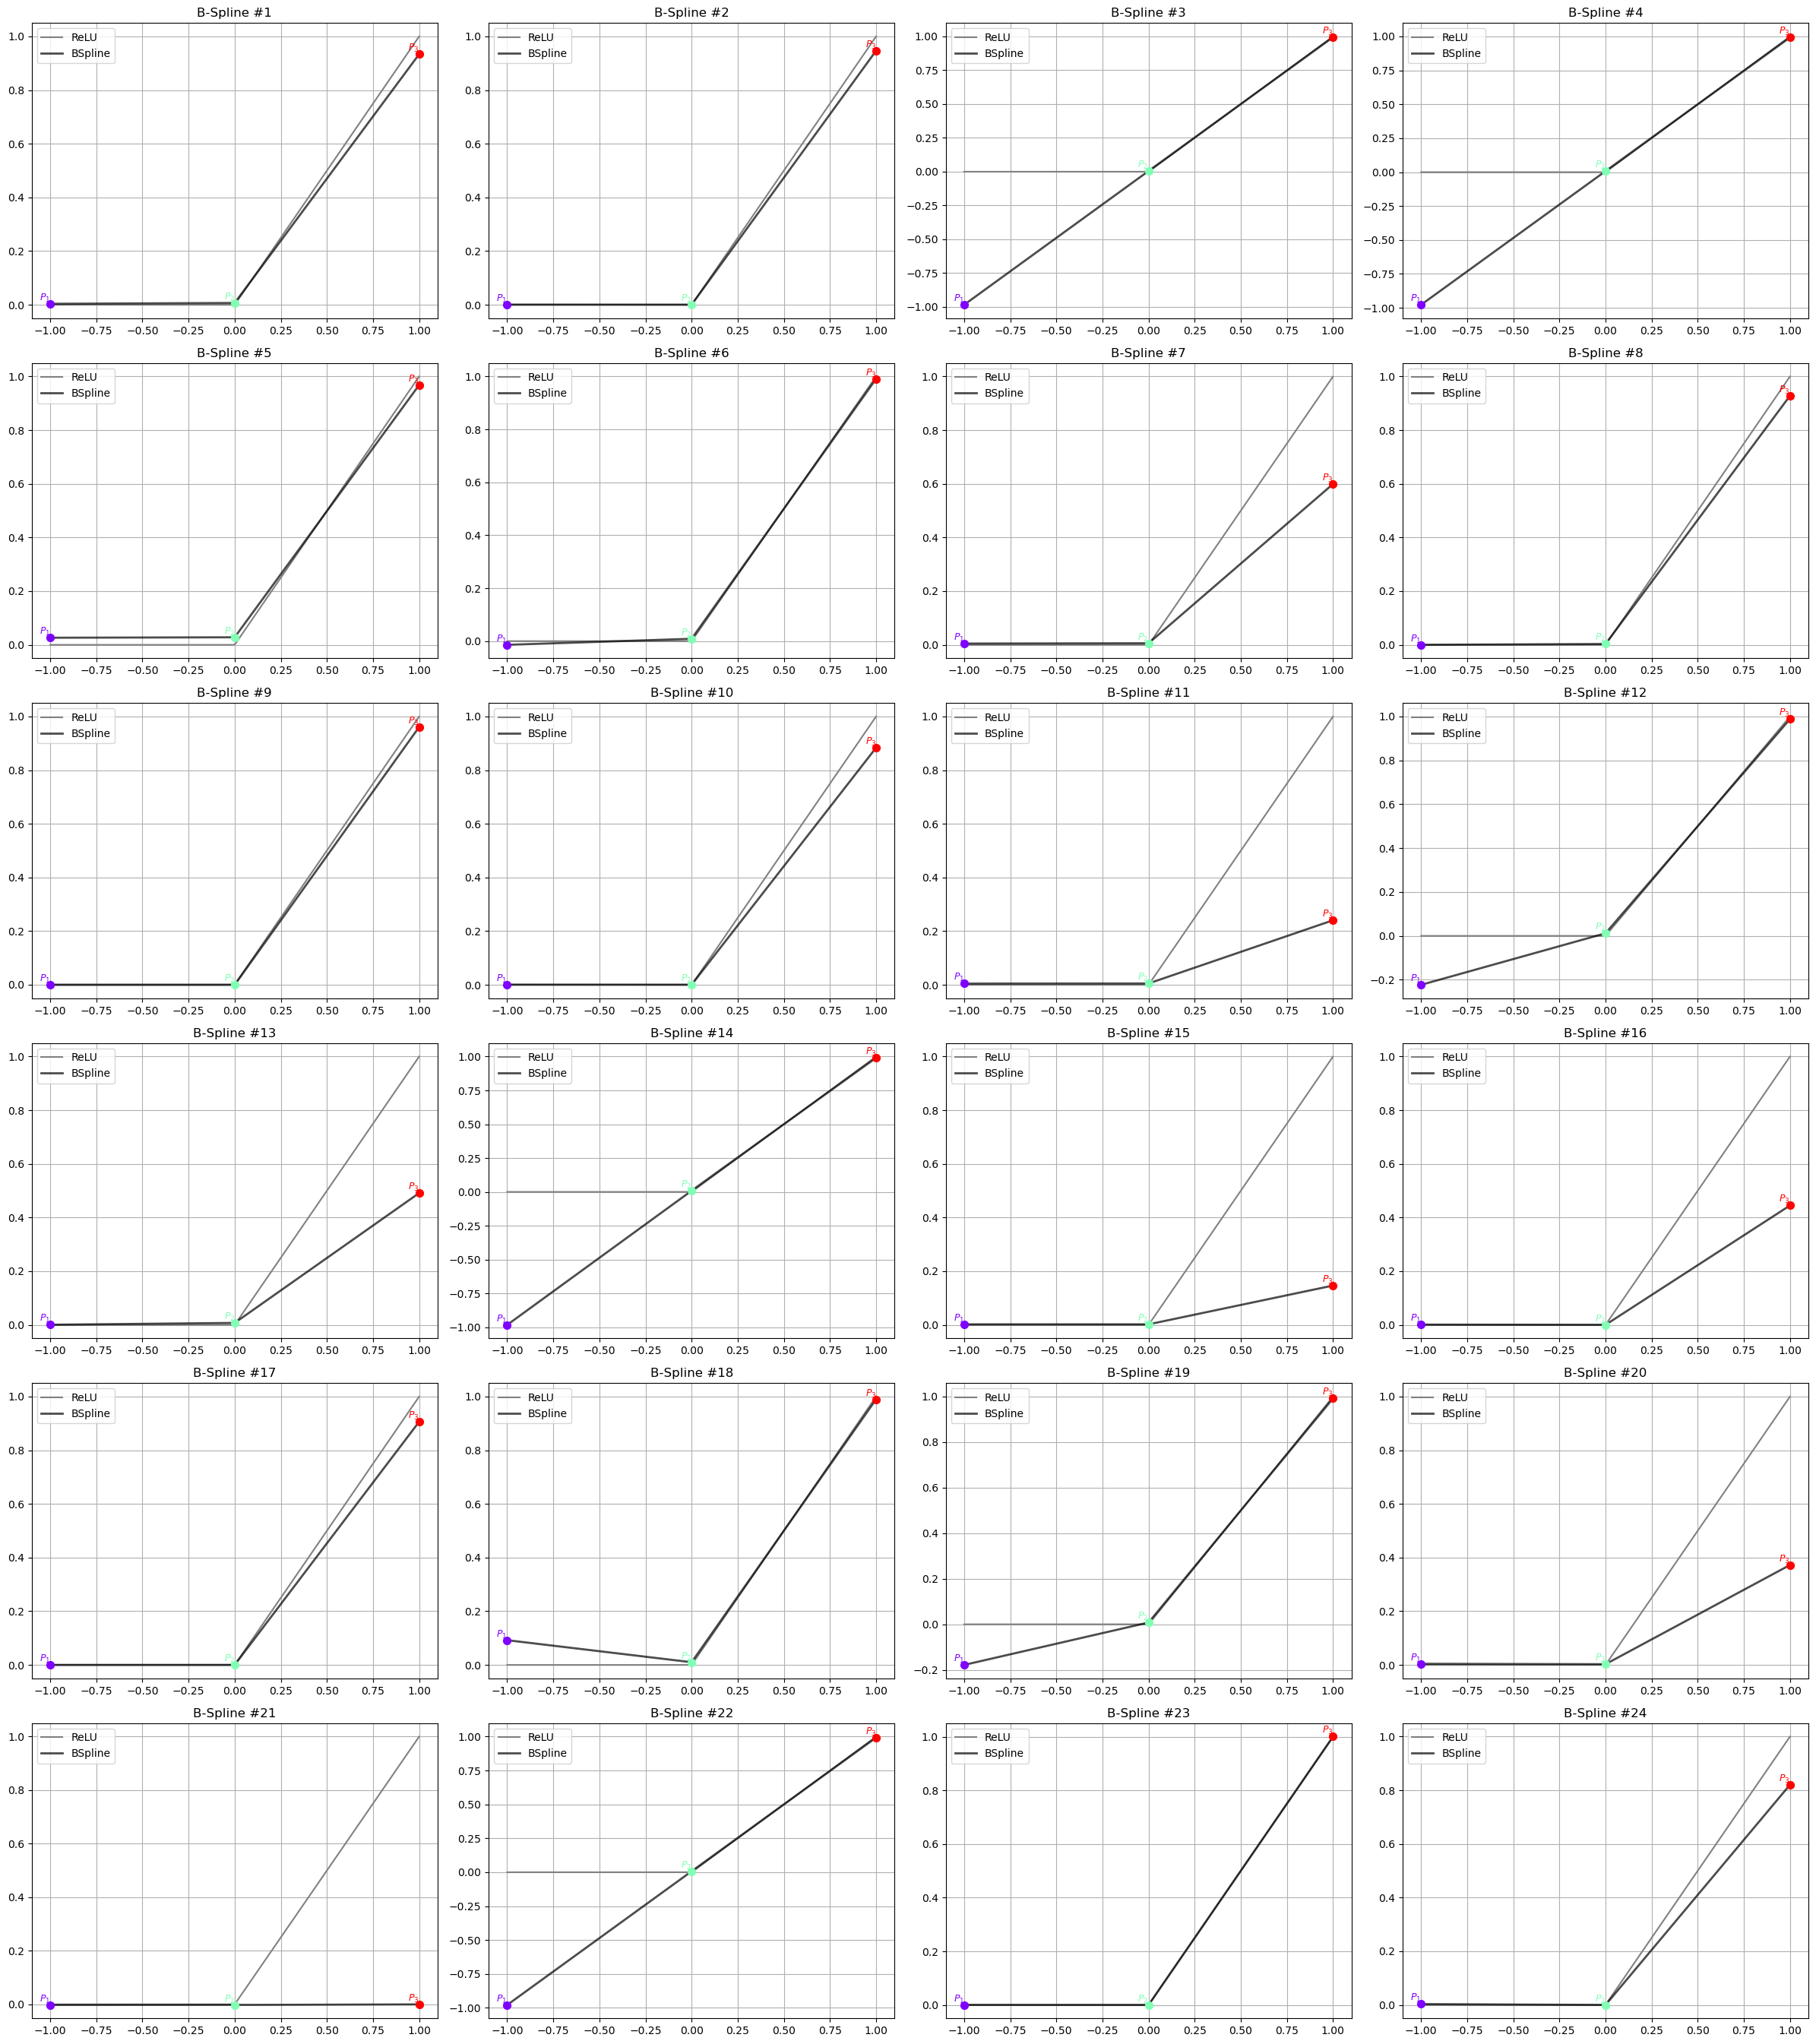

In [14]:
import sys, os
sys.path.insert(0, os.path.abspath('../DeepSplines'))
import deepsplines
import utils, importlib

importlib.reload(utils)

layer_locs = []
layer_coeffs = []
for layer in bsm.get_layers():
    if(type(layer) is deepsplines.ds_modules.deepBspline.DeepBSpline):
        layer_locs.append(layer.grid_tensor.detach())
        layer_coeffs.append(layer.coefficients_vect.view(layer.num_activations, layer.size).detach())

# print(layer_locs)
# print(layer_coeffs)
utils.plot_bsplines(layer_locs[0], layer_coeffs[0], 4)

In [1]:
import time, importlib, utils
from models import LinearReLU
from utils import run_layer

importlib.reload(linspline)

reluModel = LinearReLU([8])
layer = reluModel.layers[1]
print("Relu:")
run_layer(layer, 8)
run_layer(reluModel, 8)

print("\n ---- \n")

layer = bsm.get_layers()[1]
print("BSpline:")
run_layer(layer, 8)
run_layer(bsm, 8)

print("\n ---- \n")


print("Transferred LSpline: ")
lin = linspline.LSplineFromBSpline(bsm.get_layers())
layer = lin.get_layers()[1]
print("LSpline:")
run_layer(layer, 8)
run_layer(lin, 8)


# layer_locs = layer.grid_tensor.detach()[0]
# layer_coeffs = layer.coefficients_vect.view(layer.num_activations, layer.size).detach()[0]
# utils.plot_bspline(layer_locs, layer_coeffs, hide_bases=True)

NameError: name 'linspline' is not defined

In [18]:
lin_layer = linModel.get_layers()[1]
(linlocs, lincoeffs) = lin_layer.get_locs_coeffs()
# utils.plot_bspline(linlocs[0], lincoeffs[0], hide_bases=True)

Transferred LSpline
time:  293.79199258983135
tensor([[-0.2737, -0.0244],
        [ 0.0382,  0.0082],
        [ 1.8457,  0.0412]])


In [19]:
lin_optimizer = optim.Adam(linModel.parameters(), lr=0.001)

print("Init complete")

linModel.train()
for epoch in range(10):
    rloss = 0
    for X_batch, y_batch in train_loader:
        lin_optimizer.zero_grad()

        y_pred = linModel(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        rloss += loss
    print(f"Epoch {epoch}: {rloss}")

layer = linModel.get_layers()[1]
run_layer(layer, input)

Init complete
Epoch 0: 1173.4237060546875
Epoch 1: 1279.8961181640625
Epoch 2: 1145.614990234375
Epoch 3: 1148.69677734375
Epoch 4: 1183.909423828125
Epoch 5: 1157.4105224609375
Epoch 6: 1178.8897705078125
Epoch 7: 1164.2030029296875
Epoch 8: 1176.5655517578125
Epoch 9: 1152.094482421875
time:  320.02292573451996
tensor([[-0.2737, -0.0244],
        [ 0.0382,  0.0082],
        [ 1.8457,  0.0412]])


In [ ]:
from models import LinearRelu

relu = LinearRelu([8])
optimizer = optim.Adam(bsm.parameters_no_deepspline(), lr=0.001)

print("Init complete")

relu.train()
for epoch in range(100):
    rloss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        y_pred = bsm(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss2 = loss + lmbda * bsm.TV2()
        loss2.backward()
        optimizer.step()
        
        rloss += loss
    if(epoch % 5 == 0):
        print(f"Epoch {epoch}: {rloss}")

In [1]:
import matplotlib.pyplot as plt

x = [torch.linspace(-1, 1, 1000, dtype=torch.float)]

# Compute y values based on the new function
y1 = layer(x)
y2 = lin_layer(x)

# # Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y1, label='BSpline', color='red', alpha = .5)
plt.plot(x, y2, label='LSpline', color='blue', alpha = .5)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

NameError: name 'torch' is not defined

In [1]:
import utils, importlib
importlib.reload(utils)

utils.train_model_plot_layer_activations(layers=[24, 8], epochs={"relu": 200, "both": 0, "bspline": 20})

[2025-01-21 19:15:17,010] [WARNING] [real_accelerator.py:174:get_accelerator] Setting accelerator to CPU. If you have GPU or other accelerator, we were unable to detect it.
[2025-01-21 19:15:17,061] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cpu (auto detect)
Init complete
Training relu
Epoch 0: 140450.65625
Epoch 5: 3517.88330078125
Epoch 10: 1181.6396484375
Epoch 15: 985.0185546875
Epoch 20: 895.56298828125
Epoch 25: 878.5764770507812
Epoch 30: 856.1460571289062
Epoch 35: 855.5460815429688
Epoch 40: 849.171142578125
Epoch 45: 843.3131713867188
Epoch 50: 839.9215087890625
Epoch 55: 842.193359375
Epoch 60: 836.2014770507812
Epoch 65: 826.9216918945312
Epoch 70: 838.1798706054688
Epoch 75: 821.0269775390625
Epoch 80: 812.0990600585938
Epoch 85: 818.0192260742188
Epoch 90: 829.6980590820312
Epoch 95: 817.6530151367188
Epoch 100: 809.8793334960938
Epoch 105: 811.4397583007812
Epoch 110: 812.0806274414062
Epoch 115: 806.5604858398438
Epoch 120: 804.276123046

Init complete
Training relu 150
Loss at end of ReLU cycle 0,150: 912.2386474609375
Training bspline 10
Loss at end of Bspline cycle 0,10: 836.3623657226562
Training relu 50
Loss at end of ReLU cycle 1,50: 877.09375
Training bspline 10
Loss at end of Bspline cycle 1,10: 822.968505859375
Training relu 50
Loss at end of ReLU cycle 2,50: 828.3374633789062
Training bspline 10
Loss at end of Bspline cycle 2,10: 786.26318359375
Training relu 50
Loss at end of ReLU cycle 3,50: 813.5106201171875
Training bspline 10
Loss at end of Bspline cycle 3,10: 779.8807373046875
Training relu 50
Loss at end of ReLU cycle 4,50: 794.0220336914062
Training bspline 10
Loss at end of Bspline cycle 4,10: 775.5734252929688
Training complete
[991879.4375, 2360.267578125, 1987.08837890625, 2119.32958984375, 2809.783935546875, 2636.101318359375, 2458.142333984375, 2377.75439453125, 2525.06298828125, 3796.81201171875, 4309.9619140625, 2590.576904296875, 4182.9169921875, 1811.6322021484375, 1968.6845703125, 2874.54907

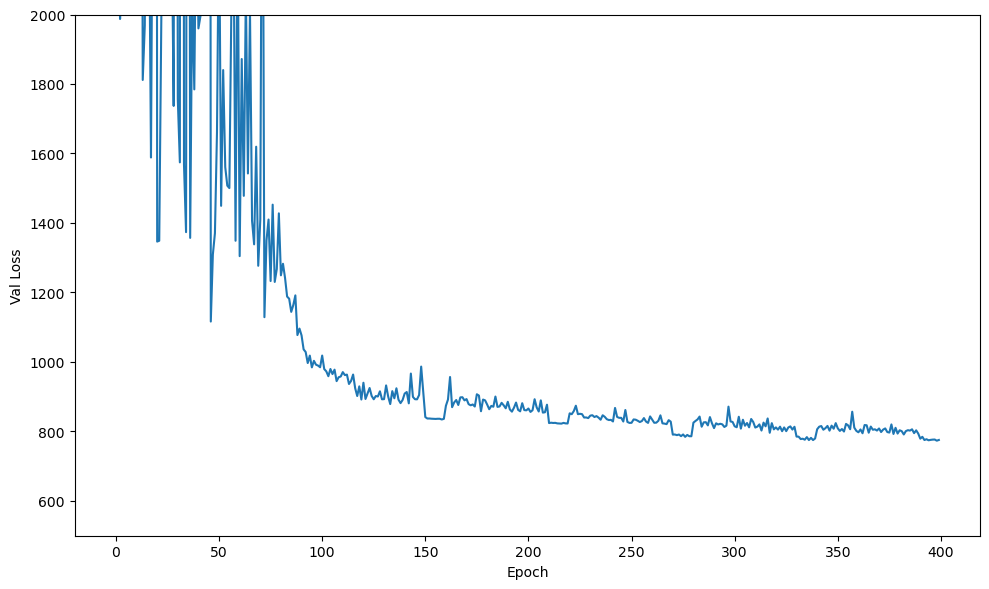

In [8]:
import utils, importlib
importlib.reload(utils)

utils.test_cycle_training(
    layers=[8],
    relu_epochs=   [150,50,50,50,50], # ,50,50,50,50,50,50,50], 
    bspline_epochs=[10,10,10,10,10], #,10,10,10,10,10,10,10]
    y_clamp=[500,2000]
)

In [4]:
import utils, importlib
importlib.reload(utils)

df = utils.test_cycle_training(
    layers=[8],
    wb_epochs=[150,50,50,50,50], 
    af_epochs=[10,10,10,10,10],
)

Init complete
Training relu 150
Loss at end of ReLU cycle 0,150: 0.49271583557128906
Training bspline 10
Loss at end of Bspline cycle 0,10: 0.3757532835006714
Training relu 50
Loss at end of ReLU cycle 1,50: 0.11586499214172363
Training bspline 10
Loss at end of Bspline cycle 1,10: 0.1747497320175171
Training relu 50
Loss at end of ReLU cycle 2,50: 0.045572251081466675
Training bspline 10
Loss at end of Bspline cycle 2,10: 0.5390884876251221
Training relu 50
Loss at end of ReLU cycle 3,50: 0.9545772671699524
Training bspline 10
Loss at end of Bspline cycle 3,10: 0.10526151955127716
Training relu 50
Loss at end of ReLU cycle 4,50: 0.20331469178199768
Training bspline 10
Loss at end of Bspline cycle 4,10: 0.1864641010761261
Training complete


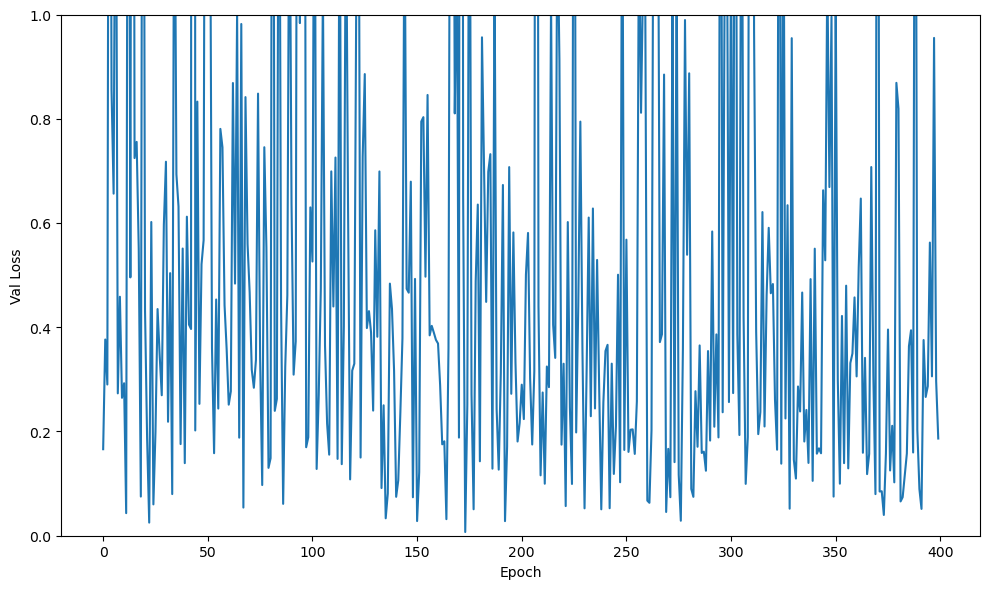

In [7]:
# Plotting with Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=df, x="Epoch", y="Val Loss", markers=False)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [11]:
import utils, importlib
importlib.reload(utils)

utils.train_models_count_zeroed_AFs(runs=1, layers=[[8]], epochs={"relu":200, "both": 0, "bspline":10})

Layer: [8]
Run: 0


In [ ]:
# CPU vs GPU

### Testing Fwd Latency Across Activations

In [18]:
import sys, os, torch, time, importlib
import torch.nn as nn
sys.path.insert(0, os.path.abspath('../DeepSplines'))
import deepsplines
import linspline
import models
importlib.reload(linspline)
importlib.reload(models)

per=100000
batch_size=1

inpts = 2 * torch.rand(per,batch_size) - 1

# relu = nn.ReLU()
start_time = time.perf_counter()
for i in range(per):
    _ = relu(inpts[i])
end_time = time.perf_counter()
print(f"ReLU (torch) time to process {len(inpts)}: {end_time-start_time}")

relu_not_optimized = lambda x: max(0,x)
start_time = time.perf_counter()
for i in range(per):
    _ = relu_not_optimized(inpts[i])
end_time = time.perf_counter()
print(f"ReLU (manual) time to process {len(inpts)}: {end_time-start_time}")

wrapped_inpts = [x.unsqueeze(0) for x in inpts]
bspline = models.SingleBSpline(size=3, grid_value=1)

start_time = time.perf_counter()
for i in range(per):
    _ = bspline.forward(wrapped_inpts[i])
end_time = time.perf_counter()
print(f"BSpline time to process {len(inpts)}: {end_time-start_time}")

lspline=linspline.LinearSpline(locs=torch.tensor([-1.0,0.0,1.0]), coeffs=bspline.get_coeffs_vect())
start_time = time.perf_counter()
for i in range(per):
    _ = lspline.forward(inpts[i])
end_time = time.perf_counter()
print(f"LSpline time to process {len(inpts)}: {end_time-start_time}")

ReLU (torch) time to process 100000: 0.6785251908004284
ReLU (manual) time to process 100000: 0.9893941869959235
BSpline time to process 100000: 9.60750793479383
LSpline time to process 100000: 8.93493770621717


In [33]:
import time, importlib, utils
from models import LinearReLU, LinearBSpline

importlib.reload(utils)

batch_size = 10
num_inputs = 100000
arch = [8]
first_layer_input_dim = arch[0]
model_input_dim = 8

reluModel = LinearReLU(arch)
layer = reluModel.layers[1]
print(layer)
print("Just activations layer: ", utils.run_layer(layer, first_layer_input_dim, batch_size, num_inputs))
print("Full model: ", utils.run_layer(reluModel, model_input_dim, batch_size, num_inputs))

print("\n ---- \n")

bsm = LinearBSpline(arch, 3, 1, "relu")
layer = bsm.get_layers()[1]
print(layer)
print("Just activations layer: ", utils.run_layer(layer, first_layer_input_dim, batch_size, num_inputs))
print("Full model: ", utils.run_layer(bsm, model_input_dim, batch_size, num_inputs))

print("\n ---- \n")


print("Transferred LSpline: ")
lin = linspline.LSplineFromBSpline(bsm.get_layers())
layer = lin.get_layers()[1]
print(layer)
print("Just activations layer: ", utils.run_layer(layer, first_layer_input_dim, batch_size, num_inputs))
print("Full model: ", utils.run_layer(lin, model_input_dim, batch_size, num_inputs))

ReLU()
Just activations layer:  2.499903831165284
Full model:  5.660598955117166

 ---- 



TypeError: size should be an odd number.

In [5]:
import torch

size=3
grid=1
num_activations=1

grid_arange = torch.arange(-(size // 2),
                                   (size // 2) + 1).mul(grid)

print(grid_arange.expand((num_activations, size)))

tensor([[-1,  0,  1]])
